In [47]:
import os
import sys
import collections
import tensorflow as tf
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")
print (a)

sys.path.append(a)

## PLOTTING 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting


### IMPORT FROM CURRENT PROJECT
import progress_learner
import config
import project
from project import Project

### RL module
from rl import action_learner, value_estimator, action_learner_search
from rl import block_movement_env

D:\git\learn-to-perform\strands_qsr_lib\qsr_lib\src3


In [84]:
### RELOAD modules here
reload(config)
reload(value_estimator)
reload(block_movement_env)
reload(progress_learner)


### MAIN CODE
tf.reset_default_graph()

c = config.Config()

global_step = tf.Variable(0, name="global_step", trainable=False)

policy_est = value_estimator.PolicyEstimator(c)
value_est = value_estimator.ValueEstimator(c)

sess =  tf.Session()

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

# action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]
action_types = ["SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load(os.path.join('..' , 'learned_models', p_name))

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training = False,
                                                                                    is_dropout = False, 
                                                                                    name = projects[project_name].name, 
                                                                                    config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, os.path.join('..' , 'learned_models', 'progress_' + project_name + '.mod.1'))

Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
INFO:tensorflow:Restoring parameters from ..\learned_models\progress_SlideAround.mod.1


In [85]:
reload(action_learner)
reload(action_learner_search)
c.num_episodes = 1000

# Effective number of steps would be limit_step // (breadth + 1)
action_ln = action_learner.ActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 12)

past_envs, stats = action_ln.policy_learn(action_learner_search.action_policy(c), breadth = 3, verbose = False,
                                          choice = 'REINFORCE', default = False)

Step 2 @ Episode 1000/1000 (0.4030837416648865), (sigma = [1.00069339 1.00069339])))

In [13]:
a.flatten()

array([2, 2])

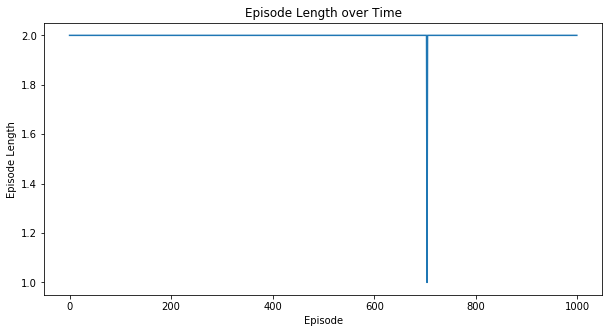

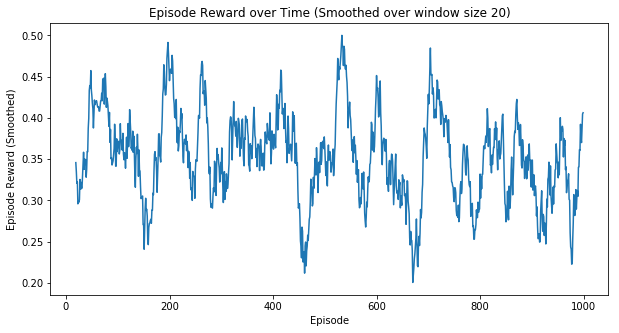

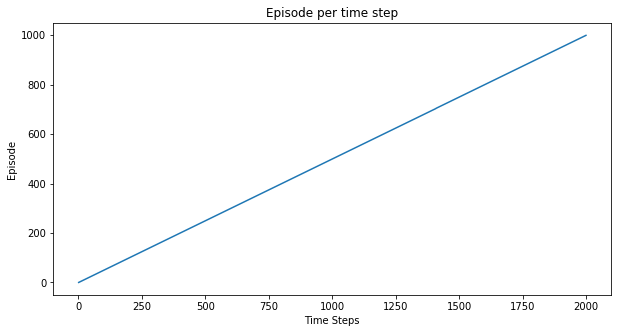

(<matplotlib.figure.Figure at 0x14c2adbc748>,
 <matplotlib.figure.Figure at 0x14c46e42668>)

In [86]:
plotting.plot_episode_stats(stats, smoothing_window=20)

In [72]:
stats

EpisodeStats(episode_lengths=array([5., 5., 5., ..., 0., 0., 0.]), episode_rewards=array([0.08764327, 0.51146245, 0.38589397, ..., 0.00260519, 0.        ,
       0.        ]))

In [74]:
import plotting
stats_2 = plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:1000],
            episode_rewards=stats.episode_rewards[:1000])